# ResNet

In [1]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

import pandas as pd
import numpy as np

from PIL import Image

# Load Data

In [2]:
name = 'dataWin.csv' if os.name == 'nt' else 'data.csv'

labels = pd.read_csv(name)
labels.head()

,path,value
0,/home/torak28/Desktop/Studia/MGU/Projekt/PS-Ba...,0
1,/home/torak28/Desktop/Studia/MGU/Projekt/PS-Ba...,1
2,/home/torak28/Desktop/Studia/MGU/Projekt/PS-Ba...,1
3,/home/torak28/Desktop/Studia/MGU/Projekt/PS-Ba...,1
4,/home/torak28/Desktop/Studia/MGU/Projekt/PS-Ba...,1


# Show some Data

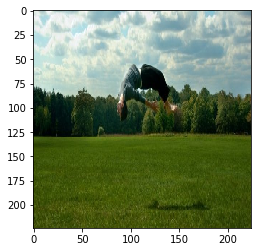

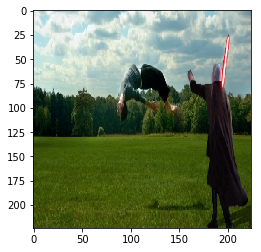

In [3]:
def get_image(path):
    img = Image.open(path)
    img = img.resize((224,224))
    img = img.convert('RGB')
    img = np.array(img)
    return img

org_row = labels[labels.value == 0].path[0]
plt.imshow(get_image(org_row))
plt.show()

ps_row = labels[labels.value == 1].path[1]
plt.imshow(get_image(ps_row))
plt.show()

# Load data to variables and split into train and test

In [4]:
from sklearn.model_selection import train_test_split
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from keras.preprocessing.image import load_img, img_to_array, array_to_img

data = []

# Load just 1/100 of data
for i in labels.path.values[::300]:
    data.append(get_image(i)) 
    
X = np.array(data, dtype=np.float32)
Y = labels.value.values[::300]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.3, random_state=1234123)

Using TensorFlow backend.


In [5]:
# Dystrybucja labelek w secie treningowym
print(f'{pd.Series(y_train).value_counts()}')
print(f'{pd.Series(y_test).value_counts()}')

print(f'Some of X: {X[0].shape}')
print(f'Some of Y: {Y[:10]}')

print(f'Some of X_train: {X_train[0].shape}')
print(f'Some of X_test: {X_test[0].shape}')

print(f'Some of y_train: {y_train[:10]}')
print(f'Some of y_test: {y_test[:10]}')


1    210
0     21
dtype: int64
1    90
0    10
dtype: int64
Some of X: (224, 224, 3)
Some of Y: [0 0 1 1 1 1 1 1 1 1]
Some of X_train: (224, 224, 3)
Some of X_test: (224, 224, 3)
Some of y_train: [1 1 1 0 1 1 1 1 1 1]
Some of y_test: [1 1 1 1 1 1 0 1 0 1]


# Normalize

[link do artykułu](https://towardsdatascience.com/deep-learning-using-transfer-learning-python-code-for-resnet50-8acdfb3a2d38)

1
(224, 224, 3)


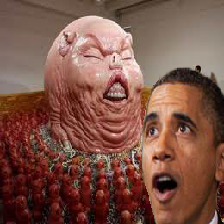

In [6]:
# Normalizacja

X_train = X_train.astype('float32') 
X_test = X_test.astype('float32') 
X_train /= 255 
X_test /= 255 

print(y_train[0]) 

# visualize a sample image 
print(X_train[0].shape) 
array_to_img(X_train[0])

# Transfer learning

In [7]:
from keras.models import Model
import keras
from keras.applications.resnet import ResNet50

IMG_WIDTH=224
IMG_HEIGHT=224

restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3))

output = restnet.layers[-1].output
output = keras.layers.Flatten()(output)

restnet = Model(restnet.input, output=output)

# Zamrożenie wag
for layer in restnet.layers:
    layer.trainable = False
    
restnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., outputs=Tensor("fl...)`
  del sys.path[0]


In [12]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(restnet)

model.add(Dense(512, activation='relu', input_dim=(224, 224)))
model.add(Dropout(0.3))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(32, activation='relu'))

# 1 dlatego że mamy tylko jedną etykietę
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=2e-5),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 100352)            23587712  
_________________________________________________________________
dense_12 (Dense)             (None, 512)               51380736  
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)              

In [13]:
history = model.fit(X_train, y_train, epochs=10, validation_split=.3, verbose=1)

Train on 161 samples, validate on 70 samples
Epoch 1/10
161/161 [==============================] - 36s 222ms/step - loss: 0.4170 - accuracy: 0.8944 - val_loss: 0.3888 - val_accuracy: 0.9143
Epoch 2/10
161/161 [==============================] - 35s 215ms/step - loss: 0.3154 - accuracy: 0.9006 - val_loss: 0.3733 - val_accuracy: 0.9143
Epoch 3/10
161/161 [==============================] - 35s 216ms/step - loss: 0.2487 - accuracy: 0.9068 - val_loss: 0.3971 - val_accuracy: 0.9143
Epoch 4/10
161/161 [==============================] - 33s 203ms/step - loss: 0.1961 - accuracy: 0.9130 - val_loss: 0.4080 - val_accuracy: 0.9143
Epoch 5/10
161/161 [==============================] - 35s 214ms/step - loss: 0.1391 - accuracy: 0.9503 - val_loss: 0.3965 - val_accuracy: 0.9143
Epoch 6/10
161/161 [==============================] - 39s 242ms/step - loss: 0.1257 - accuracy: 0.9379 - val_loss: 0.3747 - val_accuracy: 0.9143
Epoch 7/10
161/161 [==============================] - 37s 228ms/step - loss: 0.0937 -

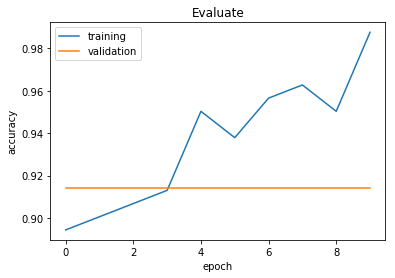

Test loss: 0.34
Test accuracy: 0.9


In [14]:
loss, accuracy  = model.evaluate(X_test, y_test, verbose=False)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(f'Evaluate')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')


In [15]:
model.save('test_resnet50.h5')

In [13]:
if os.name == 'nt':
    path = 'D:\Studia\MGU\Data\PS-Battles-master'
else:
    path = '../../MGU/Projekt/PS-Battles-master/'

org = get_image(path + 'originals/yipf7.jpg')
ps = get_image(path + 'photoshops/yipf7/c5vytne_0.jpg')

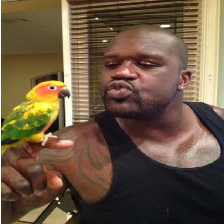

In [14]:
array_to_img(org)

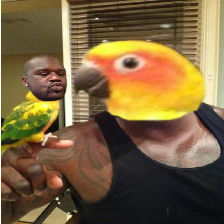

In [15]:
array_to_img(ps)

In [17]:
org = np.array(org, dtype=np.float32)
print(org.shape)
org = np.expand_dims(org, 0)
print(org.shape)

ps = np.array(ps, dtype=np.float32)
print(ps.shape)
ps = np.expand_dims(ps, 0)
print(ps.shape)

(224, 224, 3)
(1, 224, 224, 3)
(224, 224, 3)
(1, 224, 224, 3)


In [27]:
model.predict(org, verbose=1)

1/1 [==============================] - 0s 171ms/step


array([[0.9980069]], dtype=float32)

In [28]:
model.predict(ps, verbose=1)

1/1 [==============================] - 0s 165ms/step


array([[0.99916327]], dtype=float32)

# Suabo :c

# A jakby tak po prsotu to wszystko wrzucić?

In [7]:
from keras.models import Model
import keras
from keras.applications.resnet import ResNet50

IMG_WIDTH=224
IMG_HEIGHT=224

restnet = ResNet50(include_top=True, weights=None, input_shape=(IMG_HEIGHT,IMG_WIDTH,3), classes=1)
restnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [8]:
from keras import optimizers

restnet.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=2e-5),
              metrics=['accuracy'])

In [9]:
history = restnet.fit(X_train, y_train, epochs=10, validation_split=.3, verbose=1)

Train on 161 samples, validate on 70 samples
Epoch 1/10
161/161 [==============================] - 115s 713ms/step - loss: 1.4286 - accuracy: 0.9068 - val_loss: 1.3143 - val_accuracy: 0.9143
Epoch 2/10
161/161 [==============================] - 83s 517ms/step - loss: 1.4286 - accuracy: 0.9068 - val_loss: 1.3143 - val_accuracy: 0.9143
Epoch 3/10
161/161 [==============================] - 84s 524ms/step - loss: 1.4286 - accuracy: 0.9068 - val_loss: 1.3143 - val_accuracy: 0.9143
Epoch 4/10
161/161 [==============================] - 83s 513ms/step - loss: 1.4286 - accuracy: 0.9068 - val_loss: 1.3143 - val_accuracy: 0.9143
Epoch 5/10
161/161 [==============================] - 84s 524ms/step - loss: 1.4286 - accuracy: 0.9068 - val_loss: 1.3143 - val_accuracy: 0.9143
Epoch 6/10
161/161 [==============================] - 84s 519ms/step - loss: 1.4286 - accuracy: 0.9068 - val_loss: 1.3143 - val_accuracy: 0.9143
Epoch 7/10
161/161 [==============================] - 83s 518ms/step - loss: 1.4286 

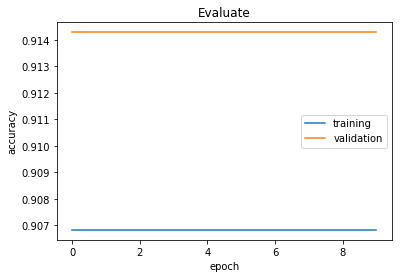

Test loss: 1.53
Test accuracy: 0.9


In [11]:
loss, accuracy  = restnet.evaluate(X_test, y_test, verbose=False)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(f'Evaluate')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')


# :c

In [19]:
restnet.predict(org, verbose=1)

1/1 [==============================] - 0s 141ms/step


array([[1.]], dtype=float32)

In [20]:
restnet.predict(ps, verbose=1)

1/1 [==============================] - 0s 150ms/step


array([[1.]], dtype=float32)